# Tensorflow of OverFeat

现在我们就来看看如何使用TensorFlow实现OverFeat,这一期我们就不在使用其他两个工具了

## 1. Classification 

首先让我们来看看OverFeat的分类部分,这里给上**fast model**的架构:

![](../../../../picture/233.png)

整个架构只有8层,layer1,layer2,layer5,使用max-pool,layer3,layer4结构参数形状不变,layer6,layer7为卷积操作.

### 1.1 LoadData

工欲善其事必先利其器,所以我们需要先加载数据集,只有处理好了数据集我们才能走好后面的路,在这里我采用的是Stanford的[stanford-dogs-dataset](https://www.kaggle.com/jessicali9530/stanford-dogs-dataset),该数据集含有20,580张不同种类狗的图片,共120类.在Annotation文件中包含了对应图片的类别以及bounding box的参数.

整个数据集的文件结构如下:

<img src="../../../../picture/246.png" height=300 width=300>

<img src="../../../../picture/247.png" height=300 width=300>

文件夹名称即为类别的名称,每个文件夹下有包含该类下的所有图片.

**Ps:**

说句实在话,该数据集数据量还是太小了,对于模型很容易就会发生过拟合,所以针对于这个数据集,我就不进行微调了.

加载数据集这里分类两步:1. 拆分数据集 2.使用TensorFlow加载数据

#### 1.1.1 Split Dataset

A.由于我们这里的类别较多,所以我们需要先创建一个"类别-index"的文件,以方便与我们以后重复利用此文件找到index对应的类别,可以使用文件夹的名字作为类型,依照for loop产生的对应的索引,由于这一步较为简单,我就不再这里贴出代码.可以产生类似于```Classes_.txt```的文件,我这里的结构如下:

<img src="../../../../picture/248.png" height=300 width=300>

也就是说**silky_terrier**的类别索引为0,**Scottish_deerhound**的类别索引为1,这样依次下去共有120个,对应数据集中的120个类别.

B.接下去我们就可以依照这个类别文件先加载一个"label-index"的字典,方便与后面添加图片的标签:

```python
def read_classes_(self):
    """
    Read classes in Classes_.txt, and build dictionary of classes_name-index.
    """
    open_ = open("../Classes_.txt", mode="r")
    lines = open_.readlines()
    for line in lines:
        line_ = line.strip()
        index, classes = line_.split()
        self.FlipClasses[classes] = int(index)
    open_.close()```

C. 下面我们就可以从Annotation文件夹入手,依次找到所有类别的文件以及其对应的```xml```文件,由于该数据集的特殊性(子文件夹名称即为类别且Annotation文件夹下的子文件夹于Image文件夹下的文件格式一样)我们直接提取文件夹即可获得该类图片的类别名称继而使用上述创建的字典找到对应的index.

```python
for a_dir in annotation_dir:
    classes_name = a_dir.split("-")[-1]
    # labels
    index = self.FlipClasses[classes_name]
    # get all xml files.
    a_path = os.path.join(Annotation_Files, a_dir)
    xml_files = os.listdir(a_path)
    for xml in xml_files:
        image_name = xml # the image name is xml name.
        # images
        image_path = os.path.join(Images_Files, a_dir,
                                  image_name + ".jpg")
        Images.append(image_path)
        Labels.append(index)```

D.最后我们拆分train/test,首先将整个加载完成的数据进行shuffle:
```python
# shuffle array, Images and Labels.
        permutation = np.random.permutation(m)
        Images = Images[permutation]
        Labels = Labels[permutation]```
        

最后通过```test_rate```来控制产生多少test数据```m_test = int(self.test_rate * m)```





E.返回加载完毕的train/test数据```sample_train, sample_test```,每一个sample里面都包含了样本Image和标签Labels.

接着使用加载完成的```sample_train, sample_test```送入TensorFlow数据加载的类```LoadData```即可,这个```LoadData```类和之前是一样的,我就不再多说了.

代码详情查看```Classification_```目录下的:[LoadData](Classification_/LoadData.py)

最后产生的结果类似于下图:

<img src="../../../../picture/249.png" height=300 width=300>
<img src="../../../../picture/250.png" height=300 width=300>

### 1.2 Build Net

有了数据的加持,我们接下来就可以搭建Net模型了.需要注意的是,我并没有按照原文的进行初始化参数的设置,也没有使用SGD,具体设置如下:

[1] **Initialization Weights and Bias:**

```python
init_weights = tf.initializers.glorot_normal()
init_bias = tf.initializers.zeros()```

[2] **Cost and Optimizer:**

```python
cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=target_hot,
                                                       logits=out))
optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(cost)```

[3] **Top-K:**这里我直接使用tensorflow的```tf.math.in_top_k```:

```python
softmax_ = tf.nn.softmax(out, axis=1)
in_top_k = tf.math.in_top_k(softmax_, labels, k)
accuracy = tf.reduce_mean(tf.cast(in_top_k, tf.float32))```

[4] **reshape**: 在使用FNC后,最后的OutPout是一个```shape=[bs,1,1,C]```的形状,我们需要将其reshaoe到```[bs,C]```的形状才能计算loss:

```python
# reshape to [batch_size, n_classes]
out = tf.reshape(C8, (-1, n_classes))```

[5] **train:**训练时候我使用的参数为:```lr=1e-4,epochs=30,dropout_rate=0.5,top_k=5,batch_size=64, test_rate=0.1```

经过大约3个小时后训练结果如下:

![](../../../../picture/251.png)

可以看到模型严重严重严重的过拟合,哎实在没有时间调了,最重要的是数据量也不够.用那句"技术下界达到需求上界即可"来骗自己好了.

代码详情查看```Classification_```目录下的:[Classification](Classification_/Classification.py)

当模型训练完毕之后,我们就可以使用OverFeat的亮点**Multi-Scale**来搭建预测脚本了.

### 1.3 Multi-Scale 

A.根据论文需要生成6种不同的尺度,而我这里只使用了两种((245,245),(281,317)),因为对于当前的情况如果使用6种效果反而会下降.于是我们使用```ScalImage```resize不同的目标尺度,继而分别送入网络进行预测:

```python
def scal_(self):
    """
    scale image to multi-images.

    Return:
    -------
        scal_samples(array): it's have different size of predict image.
    """
    Scal_list = []
    image = Image.open(self.image_path)
    for height, width in scal_image:
        resize_image = image.resize((height, width))
        resize_image = np.array(resize_image)
        w, h, c = resize_image.shape
        resize_image = resize_image.reshape((h, w, c))
        array_image = np.array(resize_image) / 255.
        Scal_list.append(array_image)

    return Scal_list```

B. 我们需要写出offset的流程依据($\Delta x,\Delta y$,$(3\times 3)$)创建一个迭代器:
```python
def offset(self, image):
    """
    implementation offset pooling.
    reference:
        Paragraph 3.3 (Multi-scale classification) Figure 3
        "https://arxiv.org/pdf/1312.6229.pdf"
    """
    for x in range(0, 3):
        for y in range(0, 3):
            offset_image = image[x:, y:, :]
            # input network...
            yield offset_image```


C. 接着我们只需要重新加载训练完毕的weights和bias```def load_W_and_b(self):```,进行前向流动就OK:

```python
def predict(self, data):
    ...```
    
D. 我们使用```stats.mode```获取当前尺度下出现类别最多的那一个(也就是获取众数)作为当前尺度下的预测类别并保存当前尺度下的结果:

```python
# Gets the number of public (Mode)
counts = stats.mode(indices)[0][0][0]
self.Result.append(counts)```

F. 最后我们同样使用```stats.mode```处理最终的列表```self.Result```即可得到Multi-scale下的最可信结果:

```python
# offset
for sample in scal_samples:
    offset_ = self.offset(sample)
    while True:
        try:
            offset_image = next(offset_)
            self.predict(offset_image)
        except:
            break
predict_label = stats.mode(self.Result)[0][0]
classes_name = self.flip_classes[predict_label]
return classes_name```


下面让我们来看看最后的结果:

<img src="../../../../picture/252.png" height=800 width=800>

代码详情查看```Classification_```目录下的:[Multi_scale](Classification_/Multi_scale.py)

## 2. Regression

下面让我们来看看回归网络,首先依然是加载数据

### 2.1 LoadData

A.那么对于回归网络而言,我们需要加载bbox,应对与Annotation/xxx/xxx.xml文件中的段落应该是:

<img src="../../../../picture/253.png" height=500 width=500>

那么我们可以先来试着绘制一下这个bbox,可以使用PIL的```rectangle```函数

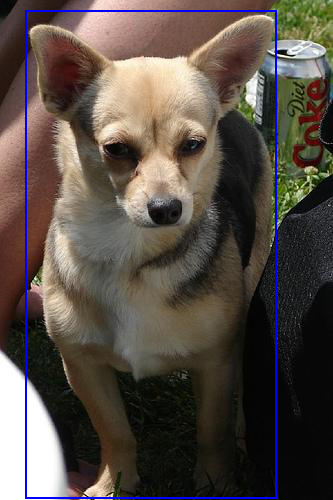

In [1]:
from PIL import Image,ImageDraw
path = '/Users/joker/jokers/DataSet/stanford-dogs-dataset/Images/n02085620-Chihuahua/n02085620_10074.jpg'
image = Image.open(path)
draw = ImageDraw.Draw(image)
draw.rectangle((25,10,276,498),outline='blue',width=2)
image

这样我们就可以绘制出bbox,但是需要注意的是,由于我们训练模型是输入是$231\times 231$,所以我们需要将bbox同比例缩小,否则无法对应于正确的位置.

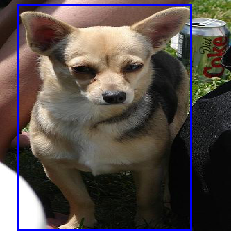

In [2]:
from PIL import Image,ImageDraw
path = '/Users/joker/jokers/DataSet/stanford-dogs-dataset/Images/n02085620-Chihuahua/n02085620_10074.jpg'
image = Image.open(path)
w,h = image.size
n_w,n_h = w/ 231,h/231
image = image.resize((231,231))
draw = ImageDraw.Draw(image)
draw.rectangle((25/n_w,10/n_h,276/n_w,498/n_h),outline='blue',width=2)
image

B. OK,现在知道了一些bbox的细节之后,我们就开始加载数据集和Classification中的LoadDta相似,不过我们会多做一些操作如```def getbbox(self, tree)```用于处理bbox的大小.

```python
N_height, N_width = (
            origin_height / resize_image[0],
            origin_width / resize_image[1],
        )
xmin, ymin = origin_xmin / N_width, origin_ymin / N_height
xmax, ymax = origin_xmax / N_width, origin_ymax / N_height
bboxs = (xmin, ymin, xmax, ymax)
return bboxs```

C. 原文中说Regression model需要有C个版本,所以我们还需要创建一个用于控制训练多少类别的函数```self.loadfiles()```,该函数用于控制你需要训练多少类别(```self.load_limit```),非常抱歉的是,我这里并没有提供“训练哪个类别“的功能.

```python
def loadfiles(self):
    """
    load classes and print current classes. 
    """
    a_files = os.listdir(self.annotation_path)
    if self.load_limit:
        a_files = a_files[:self.load_limit]
        load_classes = [f.split('-')[-1] for f in a_files]
        print('Load Classes is:\n %s' % load_classes)
    return a_files```

D. 接着弹出一个一个类别,获取相关信息后送入tensorflow的Dataset加载数据即可.

结果如下图所示:

<img src="../../../../picture/254.png" height=500 width=500>

代码详情查看```Regression_```目录下的:[LoadData](Regression_/LoadData.py)

### 2.2 Regression

将数据集准备好了之后,我们就可以着手搭建Regression model,为了简单起见,我这里只训练了一个类别```English_setter```.

A. 在OverFeat中,使用Classification model中的layer1-layer5,所以我们第一步只要加载特征层中的参数weights和bias即可:

```python
def load_w_b(self):
    ...```
    
B. 在加载完毕之后,我们需要初始化layer6-layer8的参数weights和bias:

```python
def init_w_b(self):
    ...```

C. 接下去就可以搭建模型训练了,需要注意的是,我并没有采取原文的```L2-loss```,因为我发现效果不佳转而使用```mean_squared_error```:

```python
self.cost = tf.losses.mean_squared_error(self.out, self.target_)
self.optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(
    self.cost, var_list=var_list)````
    
D. 训练完毕之后将模型保存即可.

### 2.3 IOU

在回归网络中,最重要的一个评价指标就是IOU;

IoU的全称为交并比(Intersection over Union),IoU计算的是 "预测的边框" 和 "真实的边框"的交集和并集的比值.

<img src="../../../../picture/255.png" height=300 width=300>

建议大家先看这篇博客[目标检测之 IoU](https://blog.csdn.net/u014061630/article/details/82818112).我基于这篇博客将其扩展为batch size下计算:

```python
 def Iou(self, predict_box, true_box):
    """
    Calculate Iou.
    You can see this page:
    ---------------------------------------------------------
    https://blog.csdn.net/u014061630/article/details/82818112
    ---------------------------------------------------------

    Arguments:
    ---------
        predict_box(array): predict bbox.
        true_box(array): true bbox.

    Return:
    ------
        iou(array): iou value, the shape like [bs,4].
    """
    in_w = np.minimum(predict_box[:, 2], true_box[:, 2]) - np.maximum(
        predict_box[:, 0], true_box[:, 0])
    in_h = np.minimum(predict_box[:, 3], true_box[:, 3]) - np.maximum(
        predict_box[:, 1], true_box[:, 1])

    # in_w 和in_h 都大于0 则使用面积,否则为0
    inter = np.logical_and(np.greater(in_w, 0), np.greater(
        in_h, 0)) * np.abs(in_w * in_h)

    union = np.multiply((predict_box[:,3] - predict_box[:,1]),(predict_box[:,2] - predict_box[:,0])) + \
        np.multiply((true_box[:,3] - true_box[:,1]),(true_box[:,2] - true_box[:,0])) - inter

    iou = np.divide(inter, union)
    return iou```

基于博客的内容,我们传入的形状为```shape=[bs,4]```,那么我们使用索引即可拿出两个轴计算iou,需要注意的是对于交集为空的情况我们使用一下方式:

```np.logical_and```判断逻辑and,于博客上思路相反,当```in_w,in_h```都大于0的时候,我们才使用面积,因为其小于0的全部返回的是```False```那么后面乘上```np.abs(in_w * in_h)```也是为0,所以效果和博客中```np.logical_or```的效果是一样的,只是我们这样写可以一次性判断```batch size```个iou的情况.

我们来看看训练的结果:

![](../../../../picture/256.png)

效果着实有点可怜,主要还是因为该类下的数据量太少,如果没记错的话只有120多张图片.anyway,只能到这里了.

最后将代模型保存即可.

代码详情查看```Regression_```目录下的:[Regression](Regression_/Regression.py)

### 2.4 Result

由于对于Regression的Multi-scale我并没有使用Multi-scale,主要是论文的合并算法没有搞明白,而且我尝试使用了多尺度,效果也是不尽人意,还没有训练尺度(231,231)来的好,所以这部分就不多说了,直接上结果:

<img src="../../../../picture/257.png" height=500 width=500>

效果来看还是不错的,直观上感觉IOU也能达到50%以上.

代码详情查看```Regression_```目录下的:[Multi_scale](Regression_/Multi_scale.py)

## 3. Predict

最后我们将代码整合成predict文件查看效果

<img src="../../../../picture/258.png" height=800 width=800>

代码详情查看```Tensorflow```目录下的:[predict](predict.py)